# Utah
We will be analyzing the congressional district map passed in Nov, 2021 in Utah followwing the 2020 census. Currently Utah's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election.

## Import Required Packages

In [2]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Analysis of maps by senate voting

Now that we have set up the data, we can start our analysis!

We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

In [3]:
# Read in our saved data frame
ut_data_gdf = gpd.read_file("save-new-data/utah-election-census-data-by-precincts.shp")

In [4]:
# Read in our 2021 ongressional district gdp for district boundaries
ut_2021_gdf = gpd.read_file("ut-cong-HB2004/ut-cong-HB2004.shp")

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there were four candidates that ran for the U.S. Senate: Republican Mike Lee (G22USSRLEE), Independent Evan McMullin (G22USSIMCM), Libertarian James Arthyr Hanse Oliver (G22USSLHAN), and Independent American Tommy Williams (G22USSAWIL). There was also an option to write-in a candidate (G22USSOWRI).

In [6]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ut_data_gdf.groupby('DIST2021')[['G22USSRLEE', 'G22USSIMCM','G22USSLHAN', 'G22USSAWIL', 'G22USSOWRI']].sum()

# List of candidate columns
candidate_columns = ['G22USSRLEE', 'G22USSIMCM', 'G22USSLHAN', 'G22USSAWIL', 'G22USSOWRI']

# Add a column to determine the winning candidate in each district
district_totals['Winner'] = district_totals[candidate_columns].idxmax(axis=1)

# Mapping of column names to candidate names
candidate_mapping = {
    'G22USSRLEE': 'Republican',
    'G22USSIMCM': 'Independent',
    'G22USSLHAN': 'Libertarian',
    'G22USSAWIL': 'Independent American',
    'G22USSOWRI': 'Other'
}

# Map the column names to candidate names
district_totals['Winner'] = district_totals['Winner'].map(candidate_mapping)

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

   DIST2021  G22USSRLEE  G22USSIMCM  G22USSLHAN  G22USSAWIL  G22USSOWRI  \
0         0      139577      119357        8176        3469         492   
1         1      139476      110693        8226        3241         254   
2         2      150720      126442        7826        2828          97   
3         3      142201      103467        7556        2565          65   

       Winner  
0  Republican  
1  Republican  
2  Republican  
3  Republican  


In [7]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner'].value_counts()

print(winner_summary_2021)

Winner
Republican    4
Name: count, dtype: int64


In [8]:
ut_data_gdf = ut_data_gdf.merge(district_totals_2021[["DIST2021", "Winner"]], on='DIST2021', how='left')

<Axes: >

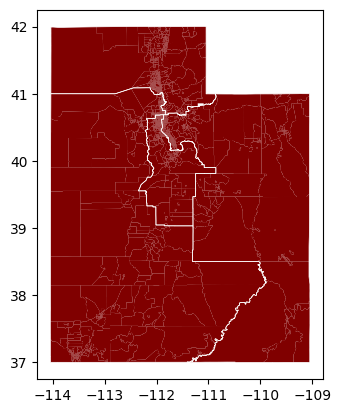

In [12]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
ut_data_gdf.plot(column = "Winner", ax=ax, cmap = "seismic_r")

# Overlay districts
ut_2021_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

### Setting up and running our Random Walk

In [14]:
ut_graph = Graph.from_file("save-new-data/utah-election-census-data-by-precincts.shp")

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column TOTPOP!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column POP1R!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column POPWH!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packag

#### Intermediate fix

In [16]:
ut_gdf = gpd.read_file("save-new-data/utah-election-census-data-by-precincts.shp")

In [17]:
clean_ga_gdf = ut_gdf.dropna()

In [18]:
ut_graph = Graph.from_geodataframe(clean_ga_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


### Return to normal coding process

In [19]:
# Make an initial districting plan

num_dist = 4 # Number of Congressional Districts in Utah
tot_pop = sum([ut_graph.nodes()[v]['TOTPOP'] for v in ut_graph.nodes()])
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(ut_graph, range(num_dist), ideal_pop, 'TOTPOP', pop_tolerance, 10)

The cases against Utah's congressional districting plan claimed that the plan was a partisan gerrymander so we will examine the voting. We will also examine the black population.

In [20]:
#Set up partition object
initial_partition = Partition(
    ut_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRLEE", alias = "R Votes"), 
        "Ind Votes": Tally("G22USSIMCM", alias = "Ind Votes")
    }
) 

In [21]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [22]:
# We contrain the opulation to say with the tolarance we set for an ideal district population
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [23]:
# Now we create our chain
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [34]:
r_ensemble = [] 
rvpop = []

for current_plan in our_random_walk: 
    # Calculate number of districts with more Repubican votes than Independent votes
    r = 0
    for i in range(num_dist):
        if current_plan["Ind Votes"][i] < current_plan["R Votes"][i]: 
            r = r + 1
    r_ensemble.append(r)

    # Calculate the percentage of republican voters for each district at each step
    rv_this_step = []
    for i in range(num_dist):
        rv_perc = current_plan["R Votes"][i]/ current_plan["district population"][i]
        rv_this_step.append(rv_perc)
    rv_this_step.sort()
    rvpop.append(rv_this_step)

rvpop_rand = np.array(rvpop)

### Analysis

In the 2021 congressional districting plan all 4 districts elected republican representatives for the House. Let's see how many republican districts are likely within the ensemble.

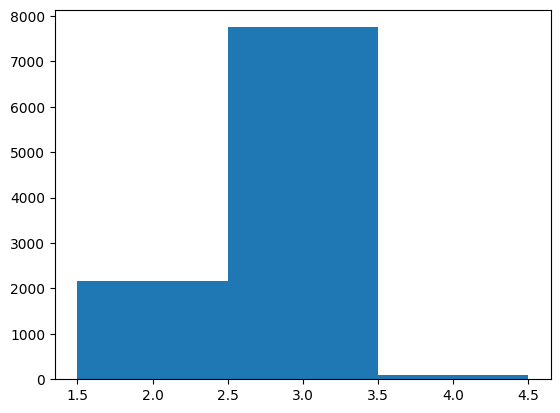

In [35]:
plt.figure()
plt.hist(r_ensemble, bins = [x + 0.5 for x in range(min(set(r_ensemble)) - 1, max(set(r_ensemble)) + 1)])
plt.show()

We see that 3 districts is most likely so it seems like the 2021 was definently racially gerrymandered,

### Mixing Time

#### Random Walk from 2021 Plan

In [36]:
#Set up partition object
initial_partition = Partition(
    ut_graph, # dual graph
    assignment = "DIST2021", # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRLEE", alias = "R Votes"), 
        "Ind Votes": Tally("G22USSIMCM", alias = "Ind Votes")
    }
) 

In [37]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [38]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [39]:
random_walk_2021 = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [41]:
r_ensemble = [] 
rvpop = []

for current_plan in our_random_walk:    
    # Calculate number of districts with more Repubican votes than Independet votes
    r = 0
    for i in range(num_dist):
        if current_plan["Ind Votes"][i] < current_plan["R Votes"][i]: 
            r = r + 1
    r_ensemble.append(r)

    # Calculate the percentage of republican voters for each district at each step
    rv_this_step = []
    for i in range(num_dist):
        rv_perc = current_plan["R Votes"][i]/ current_plan["district population"][i]
        rv_this_step.append(rv_perc)
    rv_this_step.sort()
    rvpop.append(rv_this_step)

rvpop_2021 = np.array(rvpop)

#### Compare a boxplot of the results for republican voting population

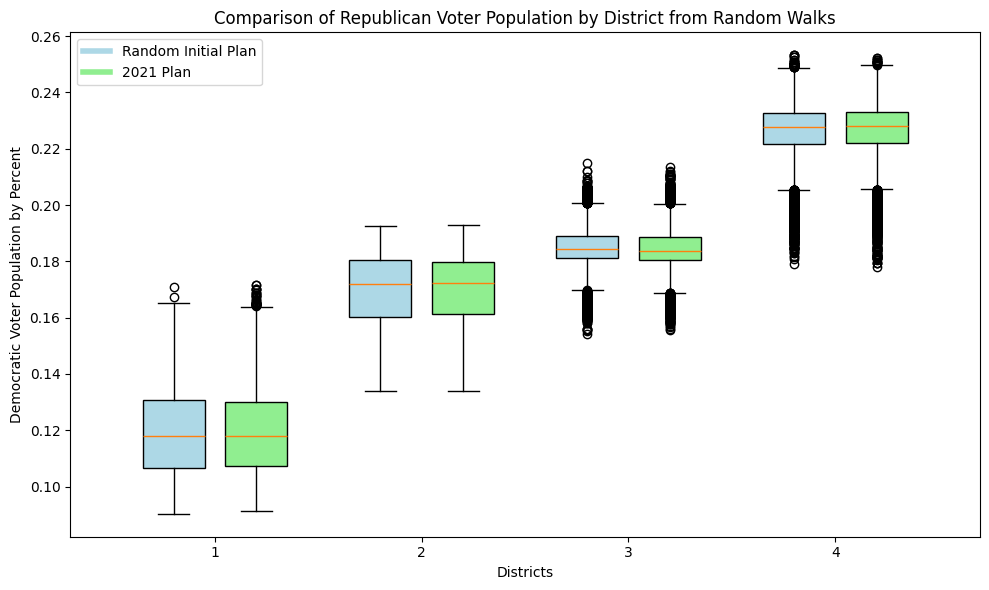

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.2 for x in range(1, num_dist + 1)]  

# Plot boxplots for black population from random initial plan
ax.boxplot(rvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(rvpop_2021, positions=positions_2021, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Republican Voter Population by Percent')
ax.set_title('Comparison of Republican Voter Population by District from Random Walks')

plt.tight_layout()
plt.show()

### Run random initial one for more 20,000 steps instead of 10,0000

In [43]:
#Set up partition object
initial_partition = Partition(
    ut_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRLEE", alias = "R Votes"), 
        "Ind Votes": Tally("G22USSIMCM", alias = "Ind Votes")
    }
) 

In [44]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [45]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [46]:
random_walk_more_steps = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 20000
)

In [47]:
r_ensemble = [] 
rvpop = []

for current_plan in our_random_walk:    
    # Calculate number of districts with more Repubican votes than Independet votes
    d = 0
    for i in range(num_dist):
        if current_plan["Ind Votes"][i] < current_plan["R Votes"][i]: 
            d = d + 1
    r_ensemble.append(d)

    # Calculate the percentage of republican voters for each district at each step
    rv_this_step = []
    for i in range(num_dist):
        rv_perc = current_plan["R Votes"][i]/ current_plan["district population"][i]
        rv_this_step.append(rv_perc)
    rv_this_step.sort()
    rvpop.append(rv_this_step)

rvpop_more_steps = np.array(rvpop)

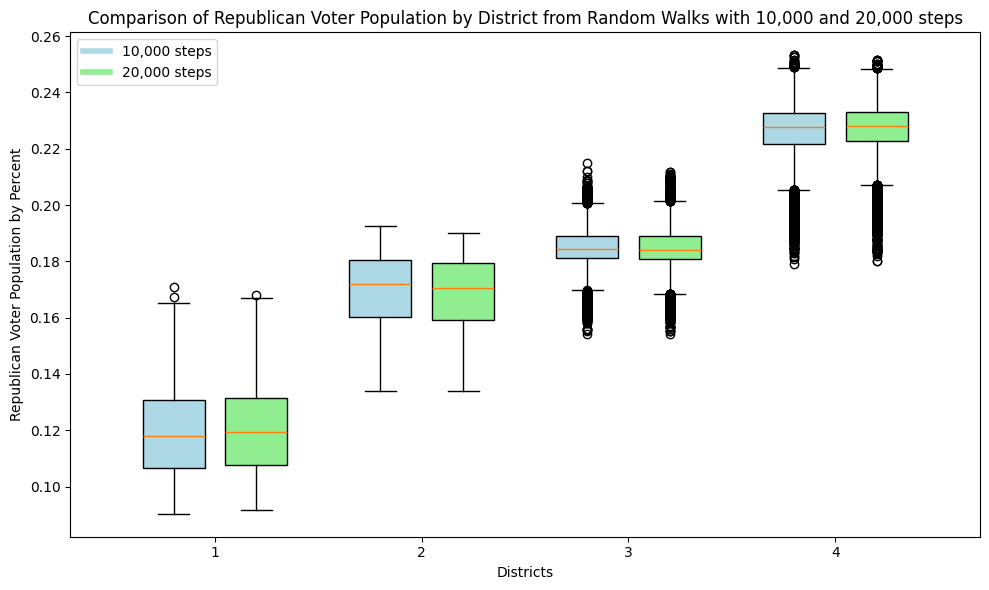

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)]  
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for republican voting population from random initial plan with 10000 steps
ax.boxplot(rvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for republican voting population from 2021 initial plan
ax.boxplot(rvpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Republican Voter Population by Percent')
ax.set_title('Comparison of Republican Voter Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()
plt.show()